In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import mobilenet as mnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

images_path = '/Users/gursharan/Desktop/images/'
labels = ['cat','dog','bird']

#### Code is referenced from https://towardsdatascience.com/cat-dog-or-elon-musk-145658489730

In [2]:
# mobile net minus the top fully connected layer and adding 3 more layers
model = mnet.MobileNet( input_shape=(224, 224, 3), include_top=False, pooling='avg' )
added_layers = 3
x = Dropout(rate=0.4)(model.output)
x = Dense(3)(x)
x = Softmax()(x)
model= Model(model.inputs, x)
for layer in model.layers[:-added_layers]:
    layer.trainable = False
model.compile( optimizer=Adam(lr=0.001), loss='categorical_crossentropy' )
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [3]:
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
datagen = ImageDataGenerator(
    preprocessing_function=mnet.preprocess_input, shear_range=0.3, zoom_range=0.3,
    horizontal_flip=True, validation_split=0.2)

ensure_folder_exists('training_aug')
training = datagen.flow_from_directory( images_path, target_size=(224, 224), 
    save_to_dir='./training_aug', subset='training')

ensure_folder_exists('validation_aug')
validation = datagen.flow_from_directory( images_path, target_size=(224, 224),
    save_to_dir='./validation_aug', subset='validation') 

Found 1199 images belonging to 3 classes.
Found 298 images belonging to 3 classes.


In [7]:
from keras_tqdm import TQDMNotebookCallback

batch_size = 32
history = model.fit_generator(
    generator=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=10,
    callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 37 steps, validate for 9 steps


Epoch 1/10
37/37 [==============================] - 67s 2s/step - loss: 0.3828 - val_loss: 0.1947


Epoch 2/10
37/37 [==============================] - 88s 2s/step - loss: 0.2611 - val_loss: 0.1627


Epoch 3/10
37/37 [==============================] - 73s 2s/step - loss: 0.2677 - val_loss: 0.1438


Epoch 4/10
37/37 [==============================] - 81s 2s/step - loss: 0.2259 - val_loss: 0.1479


Epoch 5/10
37/37 [==============================] - 71s 2s/step - loss: 0.1984 - val_loss: 0.1272


Epoch 6/10
37/37 [==============================] - 87s 2s/step - loss: 0.1648 - val_loss: 0.1172


Epoch 7/10
37/37 [==============================] - 70s 2s/step - loss: 0.1538 - val_loss: 0.1557


Epoch 8/10
37/37 [==============================] - 77s 2s/step - loss: 0.1345 - val_loss: 0.1339


Epoch 9/10
37/37 [==============================] - 77s 2s/step - loss: 0.1521 - val_loss: 0.0967


Epoch 10/10
37/37 [==============================] - 80s 2s/step - loss: 0.1383 - val_loss: 0.1136



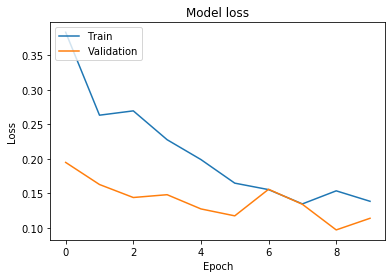

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
import random
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img( img_file, target_size=target_size) )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

random_cat = random.choice(os.listdir(images_path+'/cat/'))
cat_path = os.path.join(images_path+'/cat',random_cat)
cat = load_image(cat_path)
random_dog = random.choice(os.listdir(images_path+'/dog/'))
dog_path = os.path.join(images_path+'/dog',random_dog)
dog = load_image(dog_path)
random_bird = random.choice(os.listdir(images_path+'/bird/'))
bird_path = os.path.join(images_path+'/bird',random_bird)
bird = load_image(bird_path)

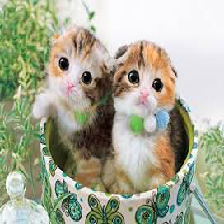

In [16]:
tf.keras.preprocessing.image.load_img(cat_path, target_size=(224,224))

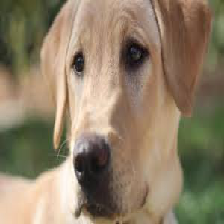

In [17]:
tf.keras.preprocessing.image.load_img(dog_path, target_size=(224,224))

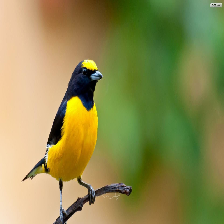

In [18]:
tf.keras.preprocessing.image.load_img(bird_path, target_size=(224,224))

In [20]:
np.round(model.predict(bird),2)

array([[1., 0., 0.]], dtype=float32)

In [21]:
np.round(model.predict(cat),2)

array([[0.01, 0.88, 0.11]], dtype=float32)

In [22]:
np.round(model.predict(dog),2)

array([[0., 0., 1.]], dtype=float32)

### Let's try it out on image with both cat and dog

[[0.   0.01 0.99]]


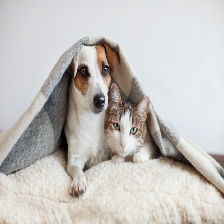

In [26]:
cat_and_dog_path = os.path.join(images_path,'cat_and_dog.jpg')
cat_and_dog = load_image(cat_and_dog_path)
print(np.round(model.predict(cat_and_dog),2) )   
tf.keras.preprocessing.image.load_img(cat_and_dog_path, target_size=(224,224))
# WE PREDICTED IT AS DOG, seems unfair for cat to be just 1%!

[[0.   0.44 0.56]]


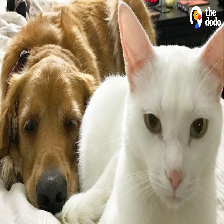

In [28]:
cat_and_dog_path = os.path.join(images_path,'cat_and_dog_2.jpg')
cat_and_dog = load_image(cat_and_dog_path)
print(np.round(model.predict(cat_and_dog),2))
tf.keras.preprocessing.image.load_img(cat_and_dog_path, target_size=(224,224))
# Model is confused between cat and dog here!

[[0.   0.78 0.22]]


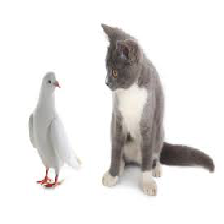

In [29]:
bird_and_cat_path = os.path.join(images_path,'bird_and_cat.jpg')
bird_and_cat = load_image(bird_and_cat_path)
print(np.round(model.predict(bird_and_cat),2))
tf.keras.preprocessing.image.load_img(bird_and_cat_path, target_size=(224,224))
# Model is confused between cat and dog here! However there is a bird too...pretty lame model!

[[0.91 0.09 0.  ]]


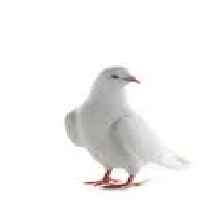

In [31]:
bird_path = os.path.join(images_path,'bird.png')
bird = load_image(bird_path)
print(np.round(model.predict(bird),2))
tf.keras.preprocessing.image.load_img(bird_path, target_size=(224,224))
# If we pass just bird, it recognizes it as bird

[[0.   0.97 0.03]]


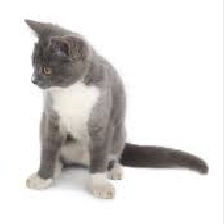

In [32]:
cat_path = os.path.join(images_path,'cat.png')
cat = load_image(cat_path)
print(np.round(model.predict(cat),2))
tf.keras.preprocessing.image.load_img(cat_path, target_size=(224,224))
# If we pass just cat, it recognizes it as cat with higher probability!
# SEEMS LIKE CAT AND BIRD IMAGE both together provide basis for dog! 

[[0.   0.99 0.01]]


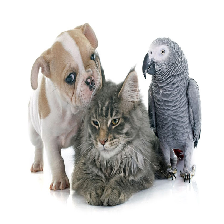

In [34]:
bcd_path = os.path.join(images_path,'bird_cat_dog.jpg')
bcd = load_image(bcd_path)
print(np.round(model.predict(bcd),2))
tf.keras.preprocessing.image.load_img(bcd_path, target_size=(224,224))